# Visualizing WIT (Wikipedia Images and Text) database using CLIP embeddings

This example creates an index on the Clip embeddings, solve searches, and also produce UMAP visualizations.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="Plots"),
    PackageSpec(name="DataFrames", version="1.3.2"),
    PackageSpec(name="JLD2", version="0.4.22"),
    PackageSpec(name="HypertextLiteral"),
])

using SimilaritySearch, SimSearchManifoldLearning, Plots, LinearAlgebra, HypertextLiteral, DataFrames, JLD2
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/WIT`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/WIT/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/WIT/Manifest.toml`
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1423


# Searching and visualizing the WIT dataset using Clip embeddings

In this demonstration, we create a SearchGraph index for searching for similarity the WIT dataset using Clip embeddings. Additionally, we produce a visualization of the entire dataset using a custom UMAP package using the index for creating an approximate all-nearest neighbors graph, since it is needed by the UMAP algorithm.

WIT is the Wikipedia-based Image and Text multimodal dataset described in 

> Srinivasan, K., Raman, K., Chen, J., Bendersky, M., & Najork, M. (2021, July). Wit: Wikipedia-based image text dataset for multimodal multilingual machine learning. In Proceedings of the 44th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 2443-2449).

Clip embeddings are described in

> Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021, July). Learning transferable visual models from natural language supervision. In International Conference on Machine Learning (pp. 8748-8763). PMLR.


## Dataset 
- dimension: 512
- size: 300K vectors
- distance: cosine

## Note

All images are linked to Wikipedia URLs. We use a precomputed set of embeddings corresponding to a small subset of the Spanish WIT.

# Retrieve the dataset and creates the index

In [2]:
begin
	url_ = "http://geo.ingeotec.mx/~sadit/similarity-search-demos"
	dbfile = "wit-es.jld2"
    embeddingsfile = "wit-embeddings.jld2"
	!isfile(dbfile) && download("$url_/$dbfile", dbfile) && nothing || nothing
    !isfile(embeddingsfile) && download("$url_/$embeddingsfile", embeddingsfile) && nothing || nothing
    db, map_ = load(dbfile, "context", "map")
end

(347174×4 DataFrame
    Row │ page_url                           image_url                         ⋯
        │ String                             String                            ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ https://es.wikipedia.org/wiki/Ju…  http://upload.wikimedia.org/wiki… ⋯
      2 │ https://es.wikipedia.org/wiki/Pa…  https://upload.wikimedia.org/wik…
      3 │ https://es.wikipedia.org/wiki/Pa…  https://upload.wikimedia.org/wik…
      4 │ https://es.wikipedia.org/wiki/Ma…  https://upload.wikimedia.org/wik…
      5 │ https://es.wikipedia.org/wiki/Mus  https://upload.wikimedia.org/wik… ⋯
      6 │ https://es.wikipedia.org/wiki/Le…  https://upload.wikimedia.org/wik…
      7 │ https://es.wikipedia.org/wiki/Su…  https://upload.wikimedia.org/wik…
      8 │ https://es.wikipedia.org/wiki/Pr…  https://upload.wikimedia.org/wik…
      9 │ https://es.wikipedia.org/wiki/Cr…  https://upload.wikimedia.org/wik… ⋯
     10 │ https://es

In [3]:
function create_or_load_index()
    X = load(embeddingsfile, "embeddings")
    for c in eachcol(X)
        normalize!(c)
    end

    dist = NormalizedAngleDistance()
    index = SearchGraph(; dist, db=MatrixDatabase(X), verbose=false)
    index!(index)
    optimize!(index, MinRecall(0.9))
    index
end

function create_umap_embeddings(index; force=true, k=100, n_epochs=200, neg_sample_rate=3, layout=RandomLayout(), tol=1e-3)
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout, if you use SpectralLayout reduce to k=15
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data's size
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    (e2=U2.embedding, e3=U3.embedding)
end


create_umap_embeddings (generic function with 1 method)

In [4]:
index = create_or_load_index()

SearchGraph{NormalizedAngleDistance, MatrixDatabase{Matrix{Float32}}, BeamSearch}
  dist: NormalizedAngleDistance NormalizedAngleDistance()
  db: MatrixDatabase{Matrix{Float32}}
  links: Array{Vector{Int32}}((318374,))
  locks: Array{Base.Threads.SpinLock}((318374,))
  hints: Array{Int32}((130,)) Int32[172, 203, 501, 773, 1047, 1089, 1138, 1359, 1364, 1471  …  7379, 7392, 7464, 7580, 7641, 7666, 7722, 7757, 7764, 287763]
  search_algo: BeamSearch
  verbose: Bool false


In [5]:
@htl("""
<h1> Searching nearest neighbors based on WIT embeddings </h1>
Select the document ID on the left slide and set the number of nearest neighbors to retrieve

<div style="background-color: rgb(30, 120, 230);">
<strong>Note:</strong> This demo doesn't compute embeddings and works with a pre-computed dataset.
</div>
""")

<h1> Searching nearest neighbors based on WIT embeddings </h1>
Select the document ID on the left slide and set the number of nearest neighbors to retrieve

<div style="background-color: rgb(30, 120, 230);">
<strong>Note:</strong> This demo doesn't compute embeddings and works with a pre-computed dataset.
</div>

In [6]:
function search_and_display(index, qID, res, db, map_)
	results = []
    search(index, index[qID], res)
	
	for (id, dist) in res
		i = map_[id]
		image = db.image_url[i]
		title = db.page_title[i]
		url = db.page_url[i]
		context = db.context_page_description[i]
		h = @htl """<div style="margin: 2em;">
		<h2>$title</h2>
		<p> $context </p>
        
        <a href="$url">$title</a> : dist: $(round(dist, digits=4))
		
        
        <div><img alt="$title" src="$image" width="30%" /></div>
        </div>
		<hr/>
		"""
		push!(results, h)
	end

	@htl """
	
		$(results)
	"""
end

search_and_display (generic function with 1 method)

In [15]:
res = KnnResult(3)
for i in 1:3
    qID = rand(1:length(index))
    i = map_[qID]
	title = db.page_title[i]
	url = db.page_url[i]
    display(@htl """<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query $qID -- <a href="$(url)">$(title)</a> </h1>""")
    search_and_display(index, qID, reuse!(res), db, map_) |> display
end

<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query 96424 -- <a href="https://es.wikipedia.org/wiki/Antonio_Zapata_y_Cisneros">Antonio Zapata y Cisneros</a> </h1>

<div style="margin: 2em;">
		<h2>Antonio Zapata y Cisneros</h2>
		<p> Antonio Zapata y Cisneros, también llamado Antonio Zapata y Mendoza, ​ fue obispo de Cádiz y Pamplona, arzobispo de Burgos y cardenal, consejero de estado de Felipe III, virrey de Nápoles e inquisidor general del reino. </p>
        
        <a href="https://es.wikipedia.org/wiki/Antonio_Zapata_y_Cisneros">Antonio Zapata y Cisneros</a> : dist: 0.0
		
        
        <div><img alt="Antonio Zapata y Cisneros" src="https://upload.wikimedia.org/wikipedia/commons/1/1d/Cardinale_Zapata.jpg" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Galería Príncipe de Nápoles</h2>
		<p> La Galleria Principe di Napoli es una galería comercial construida en Nápoles, Italia, entre 1873 y 1883. </p>
        
        <a href="https://es.wikipedia.org/wiki/Galer%C3%ADa_Pr%C3%ADncipe_de_N%C3%A1poles">Galería Príncipe de Nápoles</a> : dist: 0.4756
		
        
        <div><img alt="Galería Príncipe de Nápoles" src="https://upload.wikimedia.org/wikipedia/commons/1/16/Via_Enrico_Pesina_-_Galleria_Principe_di_Napoli_-_panoramio.jpg" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Basílica de los Santos Apóstoles</h2>
		<p> La basílica de los Santos Apóstoles es una iglesia de Roma, situada en el barrio de Trevi. </p>
        
        <a href="https://es.wikipedia.org/wiki/Bas%C3%ADlica_de_los_Santos_Ap%C3%B3stoles">Basílica de los Santos Apóstoles</a> : dist: 0.4869
		
        
        <div><img alt="Basílica de los Santos Apóstoles" src="https://upload.wikimedia.org/wikipedia/commons/d/d5/Trevi_-_palazzo_colonna_e_basilica_santi_apostoli_01.JPG" width="30%" /></div>
        </div>
		<hr/>

<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query 19294 -- <a href="https://es.wikipedia.org/wiki/%C3%81lvaro_Cienfuegos">Álvaro Cienfuegos</a> </h1>

<div style="margin: 2em;">
		<h2>Álvaro Cienfuegos</h2>
		<p> Álvaro Cienfuegos fue un eclesiástico y teólogo español, obispo de Catania, arzobispo de Monreale y cardenal. Exiliado durante la guerra de sucesión, ofició también como consejero y embajador del Sacro Imperio Romano Germánico. </p>
        
        <a href="https://es.wikipedia.org/wiki/%C3%81lvaro_Cienfuegos">Álvaro Cienfuegos</a> : dist: 0.0
		
        
        <div><img alt="Álvaro Cienfuegos" src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Alvaro_Cienfuegos_%281657-1739%29.jpg" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>José Manuel Pérez Castellano</h2>
		<p> José Manuel Pérez Castellano fue un sacerdote, político y agricultor de la Banda Oriental. </p>
        
        <a href="https://es.wikipedia.org/wiki/Jos%C3%A9_Manuel_P%C3%A9rez_Castellano">José Manuel Pérez Castellano</a> : dist: 0.543
		
        
        <div><img alt="José Manuel Pérez Castellano" src="https://upload.wikimedia.org/wikipedia/commons/b/be/Manuel_P%C3%A9rez_Castellanos_ElIndiscreto_n40.jpg" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Estudio 1</h2>
		<p> Estudio 1 fue un programa dramático producido por Televisión Española, que comenzó a emitirse el 6 de octubre de 1965 hasta 1984 y que consistía en la representación televisada de una obra de teatro. </p>
        
        <a href="https://es.wikipedia.org/wiki/Estudio_1">Estudio 1</a> : dist: 0.5671
		
        
        <div><img alt="Estudio 1" src="https://upload.wikimedia.org/wikipedia/commons/4/42/Retrato_de_Pedro_Calder%C3%B3n_de_la_Barca.jpg" width="30%" /></div>
        </div>
		<hr/>

<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query 235511 -- <a href="https://es.wikipedia.org/wiki/Plesiadapiformes">Plesiadapiformes</a> </h1>

<div style="margin: 2em;">
		<h2>Carpolestes simpsoni</h2>
		<p> Carpolestes simpsoni es una especie extinta de Plesiadapiformes, uno de los primeros mamíferos del tipo de los primates que aparecen en los registros fósiles durante el Paleoceno tardío. C. simpsoni tenía dedos capaces de agarrar, pero no tenía ojos de posición frontal.
Con un peso de aproximadamente 100 gramos, C. simpsoni se cree que estaba adaptado para un hábitat arbóreo. Tenía un dedo grande con uña opuesto a los otros dedos, lo que le permitía aferrarse bien a las ramas. Al igual que otras especies de Carpolestes, la morfología dental de C. simpsoni estaba especialmente adaptada para comer frutas, semillas e invertebrados.​ </p>
        
        <a href="https://es.wikipedia.org/wiki/Carpolestes_simpsoni">Carpolestes simpsoni</a> : dist: 0.0
		
        
        <div><img alt="Carpolestes simpsoni" src="http://upload.wikimedia.org/wikipedia/commons/5/59/CarpolestesCL.png" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Plesiadapiformes</h2>
		<p> Los plesiadapiformes son un orden extinto de mamíferos placentarios del superorden Euarchontoglires. Los primeros miembros de este grupo aparecieron en el Paleoceno inferior y se extinguieron en el Eoceno inferior.
Recientemente se ha propuesto que los plesiadapiformes representan los ancestros directos de todos los primates, lo que convertiría a estos últimos en un taxón parafilético. Algunas clasificaciones cladísticas han incluido a los primates dentro los plesiadapiformes. ​ Varias clasificaciones prefieren preservar el término &quot;Primates&quot; pero con los grupos de plesiadapiformes incluidos, los primates tradicionales se llaman &quot;Euprimates&quot; en este contexto.
Purgatorius fue un animal del tamaño de una rata que vivió en el noreste de los Estados Unidos hace 66 millones de años. ​ Ha sido descrito como el ancestro de los plesiadapiformes. </p>
        
        <a href="https://es.wikipedia.org/wiki/Plesiadapiformes">Plesiadapiformes</a> : dist: 0.0
		
        
        <div><img alt="Plesiadapiformes" src="http://upload.wikimedia.org/wikipedia/commons/5/59/CarpolestesCL.png" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Baurioidea</h2>
		<p> Los baurioideos son una superfamilia de terocéfalos terápsidos. Incluye terocéfalos avanzados como Regisaurus y Bauria.​ La superfamilia fue nombrado por el paleontólogo sudafricano Robert Broom en 1911. Bauriamorpha, nombrado por DMS Watson y Alfred Romer en 1956, es un sinónimo de Bauriodea.
Muchos baurioideos estuvieron clasificados en el grupo llamado Scaloposauridae. Los escaloposaurios se caracterizan por su pequeño tamaño y una reducida barra postorbital. La clasificación scaloposaurios ya no es reconocida como un taxón válido, ya que probablemente representa formas juveniles de muchos grupos de therocephalidos. La mayoría de scaloposaurios, incluyendo a Scaloposaurus y Regisaurus, ahora se clasifican dentro de Baurioidea.​
Un gran número de terocéfalos que fueron clasificado como escaloposaurios se consideran ahora baurioideos basales. La clasificación de estas especies es muy incierta, ya que no ha habido ningún análisis filogenético integral de taxones de escaloposaurios. La validez de muchas de estas especies es cuestionable, ya que los estudios futuros pueden encontrar algunos como sinónimos.​
A continuación se muestra una lista de estos taxones.:
Ictidosuchoides </p>
        
        <a href="https://es.wikipedia.org/wiki/Baurioidea">Baurioidea</a> : dist: 0.4232
		
        
        <div><img alt="Baurioidea" src="https://upload.wikimedia.org/wikipedia/commons/3/30/Regisaurus1DB.jpg" width="30%" /></div>
        </div>
		<hr/>

# Visualization

## Functions to create low dimensional projections

In [12]:
function create_umap_embeddings(index; k=50, n_epochs=100, neg_sample_rate=3, tol=1e-4, layout=RandomLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. More even because this example uses SpectralLayout since the number of elements allow it. Note that we are creating 2d and 3d projections

In [13]:
@time e2, e3 = create_umap_embeddings(index);

  7.572136 seconds (2.37 M allocations: 605.831 MiB)
 98.061760 seconds (2.43 M allocations: 2.023 GiB, 0.51% gc time, 0.03% compilation time)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.992550285
- embedding init: 0.006000873
- embedding opt: 66.297880459



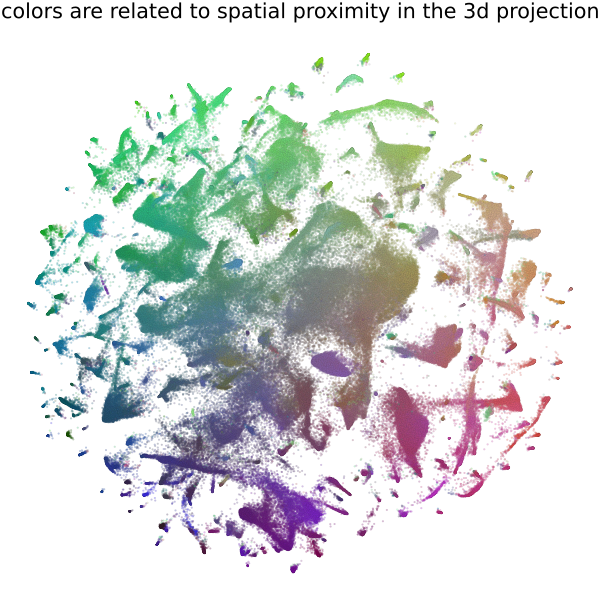

In [14]:
plot_umap(e2, e3)

# Final notes

This example shows how to index and visualize the dataset using UMAP low dimensional projections. Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [11]:
Pkg.status()

      Status `~/Research/SimilaritySearchDemos/WIT/Project.toml`
  [a93c6f00] DataFrames v1.3.2
  [ac1192a8] HypertextLiteral v0.9.4
  [033835bb] JLD2 v0.4.22
  [91a5bcdd] Plots v1.30.1
  [ca7ab67e] SimSearchManifoldLearning v0.2.4
  [053f045d] SimilaritySearch v0.9.2
